In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns


## Set up the DF and Variables

In [2]:
df = pd.read_csv('/home/upw4ys/ML_final_project-1/categorized_data.csv')

In [3]:
print(df)

       Unnamed: 0 site tree  plot   species        Date  longitude   latitude  \
0               1   AK   1A     1  P glauca  2019-01-01 -149.71571  68.018576   
1               2   AK   1A     1  P glauca  2019-02-01 -149.71571  68.018576   
2               4   AK   1A     1  P glauca  2019-05-01 -149.71571  68.018576   
3               5   AK   1A     1  P glauca  2019-06-01 -149.71571  68.018576   
4               7   AK   1A     1  P glauca  2018-07-01 -149.71571  68.018576   
...           ...  ...  ...   ...       ...         ...        ...        ...   
13632       26121   AK   6F     6  P glauca  2018-08-30 -149.76103  67.972423   
13633       26125   AK   6F     6  P glauca  2019-05-31 -149.76103  67.972423   
13634       26127   AK   6F     6  P glauca  2018-07-31 -149.76103  67.972423   
13635       26128   AK   6F     6  P glauca  2019-07-31 -149.76103  67.972423   
13636       26130   AK   6F     6  P glauca  2018-08-31 -149.76103  67.972423   

       da  mo  ...  average

In [4]:
target = 'growth_category'

In [5]:
numeric_features = [
    'average_air_temperature', 
    'average_humidity', 
    'avg_solar_irradiance', 
    'avg_soil_water_content',
    'average_air_pressure'
]

In [6]:
categorical_features = ['species', 'site', 'plot']

In [7]:
X = df[numeric_features + categorical_features]
y = df[target]

## Set up the pipelines for the Numerical and Categorical Variables

In [8]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) 
])

In [9]:
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [11]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
model.fit(X_train, y_train)

/sfs/gpfs/tardis/home/upw4ys/Documents/.conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Look at the Model Accuracy

In [21]:
print("Model Accuracy:", model.score(X_test, y_test))
print("\nClassification Report:\n")
print(classification_report(y_test, model.predict(X_test)))

Model Accuracy: 0.5641495601173021

Classification Report:

                 precision    recall  f1-score   support

A Little Growth       0.55      0.56      0.56      1276
A Lot of Growth       0.58      0.63      0.60      1286
      No Growth       0.42      0.08      0.13       166

       accuracy                           0.56      2728
      macro avg       0.52      0.42      0.43      2728
   weighted avg       0.56      0.56      0.55      2728



In [15]:
feature_names = (numeric_features + 
                 list(model.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .named_steps['encoder']
                      .get_feature_names_out(categorical_features)))

In [16]:
coefficients = pd.DataFrame(
    model.named_steps['classifier'].coef_,
    columns=feature_names,
    index=model.classes_
)

In [17]:
print("\nTop Predictors for 'A Lot of Growth':")
print(coefficients.loc['A Lot of Growth'].sort_values(ascending=False).head(10))


Top Predictors for 'A Lot of Growth':
site_NWT                   1.133141
plot_6                     0.693099
species_P mariana          0.643993
avg_solar_irradiance       0.444722
plot_2                     0.357340
avg_soil_water_content     0.165737
plot_4                     0.054268
species_P glauca           0.053463
average_air_temperature    0.039554
average_air_pressure       0.026374
Name: A Lot of Growth, dtype: float64


## Set up the coefficents dataframe so we can plot using the values generated from the model

In [27]:
cat_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_feature_names)

target_class = 'A Lot of Growth'
class_index = list(model.classes_).index(target_class)
coefficients = model.named_steps['classifier'].coef_[class_index]

df_coef = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
df_coef = df_coef.reindex(df_coef.Coefficient.abs().sort_values(ascending=False).index).head(5)

y_pred = model.predict(X_test)
report_dict = classification_report(y_test, y_pred, output_dict=True)

classes_to_plot = ['A Little Growth', 'A Lot of Growth', 'No Growth']
perf_data = {
    'Class': classes_to_plot,
    'Precision': [report_dict[c]['precision'] for c in classes_to_plot],
    'Recall':    [report_dict[c]['recall'] for c in classes_to_plot]
}
df_perf = pd.DataFrame(perf_data)
df_perf_melted = df_perf.melt(id_vars='Class', var_name='Metric', value_name='Score')


## Plot the Feature Importance and Model Performance

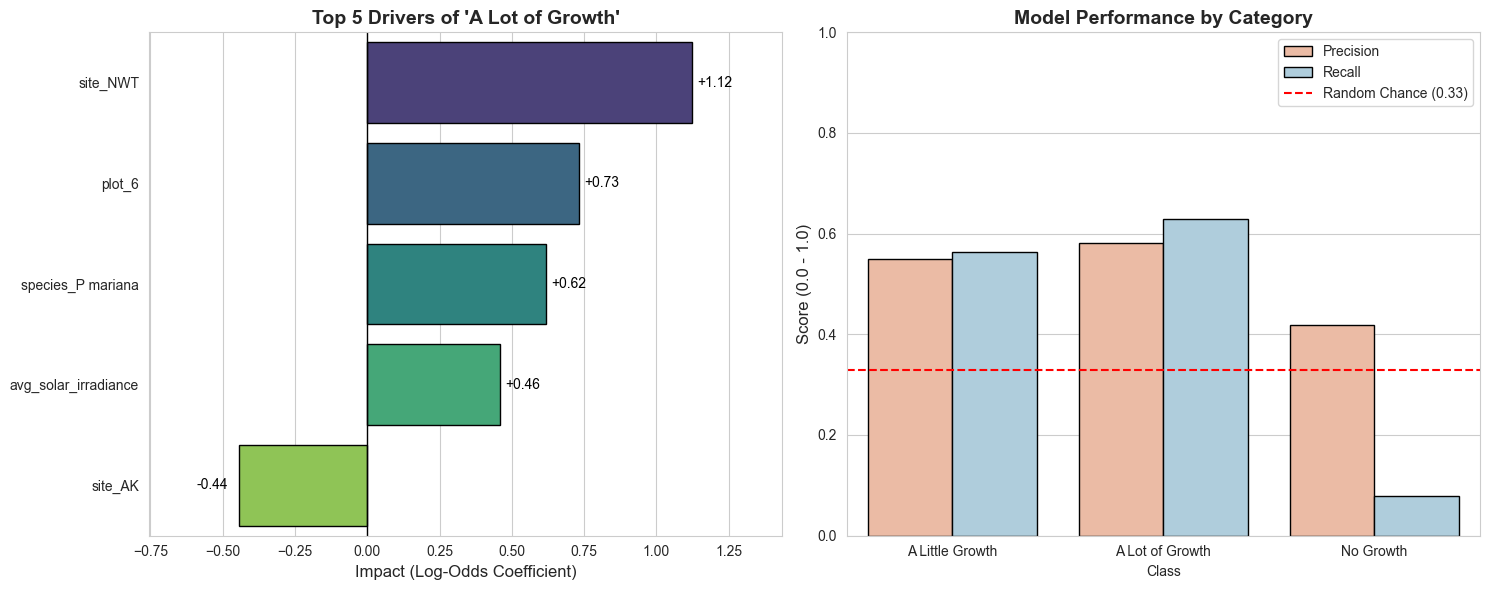

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.set_style("whitegrid")

sns.barplot(
    x='Coefficient', 
    y='Feature', 
    hue='Feature',
    data=df_coef, 
    ax=axes[0], 
    palette='viridis', 
    edgecolor='black',
    legend=False
)
axes[0].set_title(f"Top 5 Drivers of '{target_class}'", fontsize=14, weight='bold')
axes[0].set_xlabel("Impact (Log-Odds Coefficient)", fontsize=12)
axes[0].set_ylabel("")
axes[0].axvline(0, color='black', linewidth=1)

min_coef = df_coef['Coefficient'].min()
max_coef = df_coef['Coefficient'].max()
padding = max(0.3, (max_coef - min_coef) * 0.2)  
axes[0].set_xlim(min_coef - padding, max_coef + padding)

for i, v in enumerate(df_coef['Coefficient']):
    axes[0].text(v + (0.02 if v > 0 else -0.15), i, f"{v:+.2f}", va='center', fontsize=10, color='black')
    
sns.barplot(
    x='Class', 
    y='Score', 
    hue='Metric', 
    data=df_perf_melted, 
    ax=axes[1], 
    palette='RdBu', 
    edgecolor='black'
)
axes[1].set_title("Model Performance by Category", fontsize=14, weight='bold')
axes[1].set_ylim(0, 1.0)
axes[1].set_ylabel("Score (0.0 - 1.0)", fontsize=12)
axes[1].axhline(0.33, color='red', linestyle='--', label='Random Chance (0.33)')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()